In [8]:
from src.data_matching.data_matching.metrics_val import (
    f1_score,
    precision_at_n_percent,
    recall_at_sizeof_ground_truth,
    NDCG_at_n,
    GoldenStandardLoader,
)

## Functions 

In [9]:
import json
import os

def load_and_process_matches(file_path, name_s1, name_s2):
    source_table = name_s1 
    target_table = name_s2

    output_matches = {}
    # Load JSON data from the file
    with open(file_path, 'r') as f:
        list_matchs = json.load(f)
    # Convert the list of matches into a dictionary for sorting
    match_dict = {
        tuple(match["Key"]): match["Value"]
        for match in list_matchs
        if isinstance(match["Key"], list) 
        and len(match["Key"]) == 2 
        and (isinstance(match["Value"], float) or (isinstance(match["Value"], str) and match["Value"].isnumeric()))
    }

    
    # Sort the matches by score
    sorted_matches = dict(sorted(match_dict.items(), key=lambda item: item[1], reverse=True))

    # Process and format the matches
    for (source_column, target_column), score in sorted_matches.items():
        output_matches[((source_table, source_column), (target_table, target_column))] = score

    return output_matches


def get_matches(all_matches_path,file_matches):
    matches_path=os.path.join(all_matches_path,file_matches)
    matches={}
    with open(matches_path, "r") as file:
        data = json.load(file)  # Load the JSON as a Python object
    if data and isinstance(data, list):
        for key, value in data[0].items():
            try:
                parsed_key = eval(key)
                matches[parsed_key]=value
            except (SyntaxError, NameError):
                print(f"Unable to parse key: {key}")
    return matches



def calculate_scores(matches, golden_standard):
    """Calculate precision, recall, F1 scores, and NDCG at different thresholds."""
    scores = {
        "F1 Score Median": f1_score(matches, golden_standard, True),
        "NDCG at Median": NDCG_at_n(matches, golden_standard, None, True)
    }
    return scores



In [10]:
import pandas as pd
import os 

path= os.getcwd().split('/')
i=path.index('Alignment-of-schema-only-and-instance-only-data')
folder_path= "/".join(path[:i+1])

llama=pd.read_csv(folder_path+"/Results_Experiments/llama_results/llama_with_time.csv")
gpt=pd.read_csv(folder_path+"/Results_Experiments/GPT_results/gpt_with_time.csv")

## Ablation For GPT

In [12]:
from itertools import combinations
import pandas as pd
import os
df=gpt.copy()
# Path configuration
output_path = ./tests/outputs"
path_categories = "//Users/nourkired/Documents/Code/schema-matching/tests/inputs/datasets_instances"
models = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "sentence-transformers/all-MiniLM-L6-v2",
    "albert-base-v2",
    "facebook/bart-base",
    "gpt",
    "roberta-base"
]
results_ablation_combinations = pd.DataFrame()
for model in models:
    # for model in models:
    model_path = os.path.join(output_path, model)

    # Matchers and datasets
    names_datasets = []

    # Gather dataset names
    for file_matches in os.listdir(os.path.join(model_path, "matcher1_type")):
        name = os.path.basename(file_matches).replace(".json", "")
        names_datasets.append(name)

    # Initialize results DataFrame

    reel_matches=["matcher1_type","matcher2_rule", "matcher3_sch_sch", "matcher4_ins_ins", "matcher5_sch_ins_sch_ins"]
    # Perform ablation study
    for r in range(6):  # From 0 to len(matchers)
        matchers = ["matcher2_rule", "matcher3_sch_sch", "matcher4_ins_ins", "matcher5_sch_ins_sch_ins"]
        
        for ablated_matchers in combinations(matchers, r):
            ablated_matchers_set = set(ablated_matchers)
            print(f"Ablation Study: Disabling {ablated_matchers}")

            for dataset in names_datasets:
                # Reset final_matches for this dataset and combination
                final_matches = {}

                # Aggregate matches across active matchers
                for matcher in matchers:
                    if matcher in ablated_matchers_set:
                        continue  # Skip ablated matchers

                    all_matches_path = os.path.join(model_path, matcher, f"{dataset}.json")
                    try:
                        # Load matches for the matcher
                        matches_i = load_and_process_matches(all_matches_path, f"{dataset}_source", f"{dataset}_target")

                        # Aggregate matches for averaging
                        for key, value in matches_i.items():
                            if key not in final_matches:
                                final_matches[key] = {"sum": value, "count": 1}
                            else:
                                final_matches[key]["sum"] += value
                                final_matches[key]["count"] += 1
                    except Exception as e:
                        print(f"Error processing matcher {matcher} for dataset {dataset}: {e}")
                        continue

                # Compute the average for the final matches
                averaged_final_matches = {
                    key: final_matches[key]["sum"] / final_matches[key]["count"] for key in final_matches
                }

                after_matches = dict(sorted(averaged_final_matches.items(), key=lambda x: x[1], reverse=True))
                # Determine the golden standard mapping path
                try:
                    dataset_info = df[(df['Dataset Name'] == dataset) & (df['Model'] == model)]
                    mapping_path = os.path.join(
                        path_categories,
                        dataset_info.Category.unique()[0],
                        dataset_info['Relation Type'].unique()[0],
                        dataset,
                        f"{dataset}_mapping.json"
                    )

                    # Load the golden standard
                    golden_standard = GoldenStandardLoader(mapping_path)
                    scores_after = calculate_scores(after_matches, golden_standard)

                    # Store results in a DataFrame
                    new_row = pd.DataFrame({
                        "Dataset Name": dataset,
                        "Model": model,
                        "Ablated Matchers": ",".join(set(reel_matches)-set(ablated_matchers)),
                        **scores_after,
                    }, index=[0])
                    results_ablation_combinations = pd.concat([results_ablation_combinations, new_row], ignore_index=True)

                except Exception as e:
                    print(f"Error processing golden standard for dataset {dataset}: {e}")
                    continue

# Save the results to a CSV file
results_ablation_combinations.to_csv("gpt_ablation_results.csv", index=False)

# Print the results
print("Ablation Study Results:")
results_ablation_combinations


Ablation Study: Disabling ()
Ablation Study: Disabling ('matcher2_rule',)
Ablation Study: Disabling ('matcher3_sch_sch',)
Ablation Study: Disabling ('matcher4_ins_ins',)
Ablation Study: Disabling ('matcher5_sch_ins_sch_ins',)
Ablation Study: Disabling ('matcher2_rule', 'matcher3_sch_sch')
Ablation Study: Disabling ('matcher2_rule', 'matcher4_ins_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher3_sch_sch', 'matcher4_ins_ins')
Ablation Study: Disabling ('matcher3_sch_sch', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher4_ins_ins', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher3_sch_sch', 'matcher4_ins_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher3_sch_sch', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher4_ins_ins', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher3_sch_sch', 'matcher4_ins_ins', 'matcher5_sch_ins_sch_

,Dataset Name,Model,Ablated Matchers,F1 Score Median,NDCG at Median
0,assays_both_0_1_ac1_av,bert-base-uncased,"matcher5_sch_ins_sch_ins,matcher4_ins_ins,matc...",0.000000,0.000000
1,assays_both_0_1_ec_av,bert-base-uncased,"matcher5_sch_ins_sch_ins,matcher4_ins_ins,matc...",0.000000,0.000000
2,prospect_vertical_70_ac2_av,bert-base-uncased,"matcher5_sch_ins_sch_ins,matcher4_ins_ins,matc...",0.666667,0.682992
3,prospect_vertical_70_ec_ev,bert-base-uncased,"matcher5_sch_ins_sch_ins,matcher4_ins_ins,matc...",0.727273,0.727711
4,assays_horizontal_0_ac5_ev,bert-base-uncased,"matcher5_sch_ins_sch_ins,matcher4_ins_ins,matc...",0.652174,0.685063
...,...,...,...,...,...
41531,prospect_vertical_1_ac3_av,roberta-base,matcher1_type,0.000000,0.000000
41532,prospect_vertical_30_ac3_av,roberta-base,matcher1_type,0.000000,0.000000
41533,prospect_horizontal_0_ac4_av,roberta-base,matcher1_type,0.000000,0.000000
41534,prospect_horizontal_100_ac1_av,roberta-base,matcher1_type,0.000000,0.000000


In [13]:
ablation = (
    results_ablation_combinations.loc[results_ablation_combinations.Model == "gpt", :]
    .select_dtypes(include="number")  # Select only numeric columns
    .groupby(results_ablation_combinations["Ablated Matchers"])
    .aggregate(["mean", "std"])
)

# Replacing NaN values with "all"
ablation.fillna("all", inplace=True)
matcher_name_mapping = {
    "matcher1_type": "Type Matcher",
    "matcher2_rule": "Rule Matcher",
    "matcher3_sch_sch": "Schemas Matcher",
    "matcher4_ins_ins": "Instances Matcher",
    "matcher5_sch_ins_sch_ins": "Schema/Instance Matcher",
}

# Replace matcher names in "Ablated Matchers"
ablation.index = ablation.index.to_series().replace(matcher_name_mapping, regex=True)

# For combinations, ensure all matchers in each combination are renamed
ablation.index = ablation.index.to_series().apply(
    lambda x: ", ".join(matcher_name_mapping.get(m, m) for m in x.split(","))
)

ablation.columns=["F1 Score Mean","F1 Score Std","NDCG Mean","NDCG Std"]
ablation.reset_index(inplace=True)
ablation

,Ablated Matchers,F1 Score Mean,F1 Score Std,NDCG Mean,NDCG Std
0,Type Matcher,0.000000,0.000000,0.000000,0.000000
1,"Type Matcher, Schemas Matcher",0.490352,0.245780,0.695650,0.249446
2,"Type Matcher, Instances Matcher",0.560225,0.287055,0.749399,0.284340
3,"Type Matcher, Instances Matcher, Schemas Matcher",0.536393,0.277064,0.730771,0.291649
4,"Rule Matcher, Type Matcher",0.000000,0.000000,0.000000,0.000000
5,"Rule Matcher, Type Matcher, Schemas Matcher",0.490352,0.245780,0.695650,0.249446
6,"Rule Matcher, Type Matcher, Instances Matcher",0.560225,0.287055,0.749399,0.284340
7,"Rule Matcher, Type Matcher, Instances Matcher,...",0.536393,0.277064,0.730771,0.291649
8,"Rule Matcher, Schema/Instance Matcher, Type Ma...",0.523377,0.253733,0.750596,0.249324
9,"Rule Matcher, Schema/Instance Matcher, Type Ma...",0.514601,0.251673,0.740725,0.250714


In [14]:
ll=ablation.loc[ablation["Ablated Matchers"]=='Type Matcher, Instances Matcher, Schemas Matcher, Rule Matcher, Schema/Instance Matcher',:].iloc[:,1:]
ablation[["Delta F1 Score Mean","Delta NDCG Mean"]]=ablation[["F1 Score Mean","NDCG Mean"]]-ll[["F1 Score Mean","NDCG Mean"]].values
ablation

ValueError: Unable to coerce to DataFrame, shape must be (16, 2): given (0, 2)

In [49]:
# Creating a dictionary for abbreviations based on the extracted text
abbreviations = {
    "Type Matcher": "TM",
    "Rule Matcher": "RM",
    "Schemas Matcher": "SM",
    "Schema/Instance Matcher": "SIM",
    "Instances Matcher": "IM",
}

# Applying the dictionary to abbreviate the extracted labels
long_labels = [
    "Type Matcher",
    "Type Matcher, Rule Matcher",
    "Schemas Matcher, Type Matcher",
    "Schemas Matcher, Type Matcher, Rule Matcher",
    "Schema/Instance Matcher, Schemas Matcher, Type Matcher",
    "Schema/Instance Matcher, Schemas Matcher, Type Matcher, Rule Matcher",
    "Schema/Instance Matcher, Type Matcher",
    "Schema/Instance Matcher, Type Matcher, Rule Matcher",
    "Schemas Matcher, Instances Matcher, Type Matcher",
    "Schemas Matcher, Instances Matcher, Type Matcher, Rule Matcher",
    "Instances Matcher, Type Matcher",
    "Instances Matcher, Type Matcher, Rule Matcher",
    "Schema/Instance Matcher, Schemas Matcher, Instances Matcher, Type Matcher",
    "Schema/Instance Matcher, Schemas Matcher, Type Matcher, Rule Matcher, Instances Matcher",
    "Schema/Instance Matcher, Instances Matcher, Type Matcher",
    "Schema/Instance Matcher, Instances Matcher, Type Matcher, Rule Matcher",
]

# Replace long labels with abbreviated ones
short_labels = []
for label in long_labels:
    for long, short in abbreviations.items():
        label = label.replace(long, short)
    short_labels.append(label)

short_labels


['TM',
 'TM, RM',
 'SM, TM',
 'SM, TM, RM',
 'SIM, SM, TM',
 'SIM, SM, TM, RM',
 'SIM, TM',
 'SIM, TM, RM',
 'SM, IM, TM',
 'SM, IM, TM, RM',
 'IM, TM',
 'IM, TM, RM',
 'SIM, SM, IM, TM',
 'SIM, SM, TM, RM, IM',
 'SIM, IM, TM',
 'SIM, IM, TM, RM']

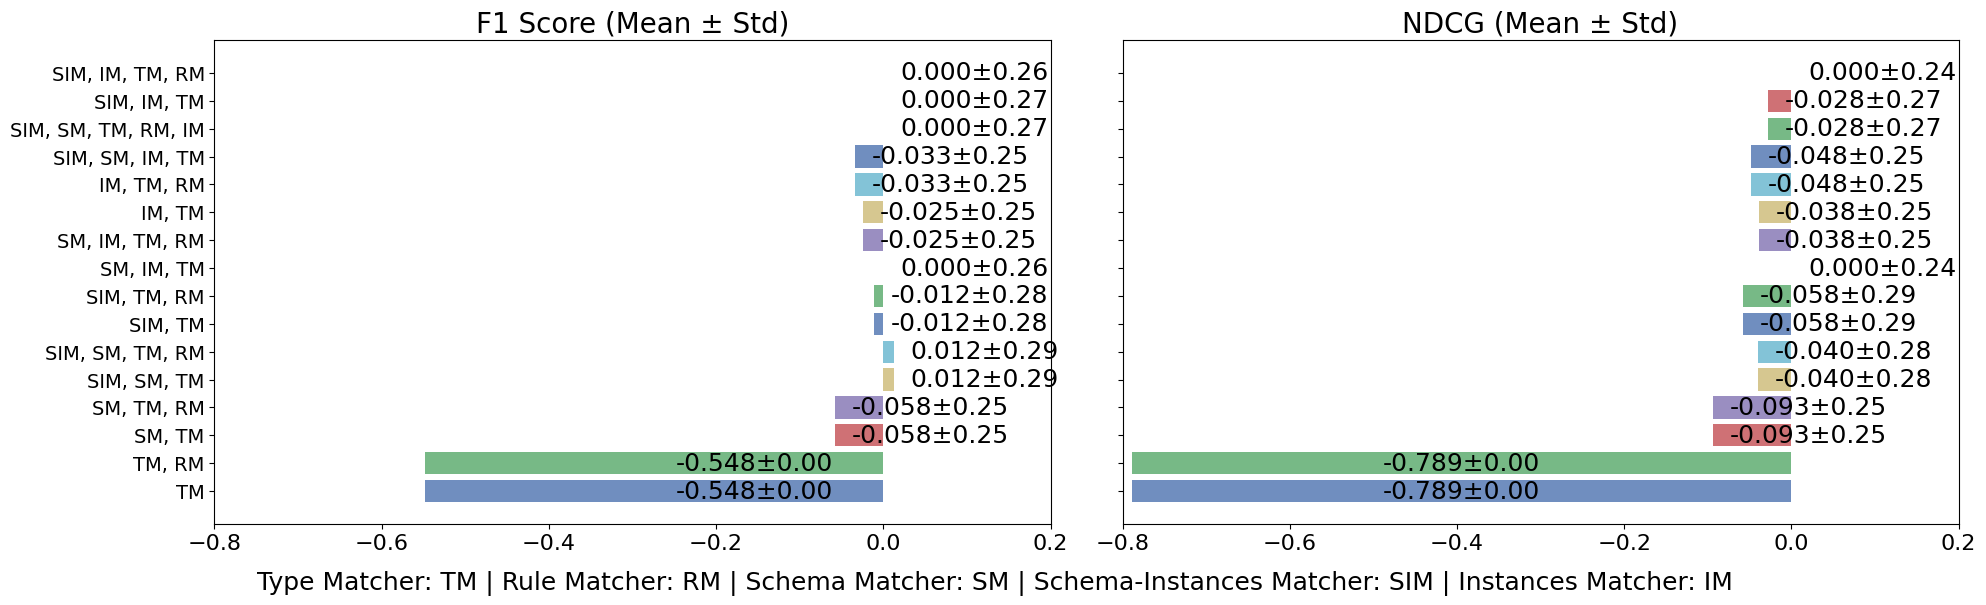

In [53]:
import matplotlib.pyplot as plt
custom_palette = [
    "#4C72B0",  # Soft Navy Blue
    "#55A868",  # Gentle Green
    '#C44E52',  # Muted Red
    "#8172B2",  # Soft Purple
    "#CCB974",  # Soft Gold
    "#64B5CD"   # Soft Teal
]

fig, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1]})

# Générer la position commune des barres
y_pos = range(len(ablation))  # Assure que l'ordre est identique pour tous les graphiques

# Boucle pour F1 Score et NDCG
metrics = [
    ("Delta F1 Score Mean", "F1 Score Std", "F1 Score (Mean ± Std)", "F1 Score", axs[0]),
    ("Delta NDCG Mean", "NDCG Std", "NDCG (Mean ± Std)", "NDCG", axs[1]),
]

for metric_mean, metric_std, title, xlabel, ax in metrics:
    for i, (mean, std, color) in enumerate(zip(ablation[metric_mean], ablation[metric_std], custom_palette * (len(ablation) // len(custom_palette) + 1))):
        ax.barh(y_pos[i], mean, color=color, alpha=0.8)
        ax.text(
            x=mean + (0.02 if mean > -0.5 else 0.3),  # Adjust text placement
            y=i,
            s=f"{mean:.3f}±{std:.2f}",
            va='center',
            fontsize=18
        )
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(" ", fontsize=16)
    ax.set_xlim(-0.8, 0.2)
    ax.tick_params(axis='x', labelsize=16)  # Adjust 'labelsize' to the desired font size


# Un seul axe Y partagé
axs[0].set_yticks(y_pos)
axs[0].set_yticklabels(short_labels, fontsize=14)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  # Supprime les labels Y du graphique de droite

# Ajuster la disposition
plt.tight_layout()

# Ajouter le texte centré en dessous des graphiques
fig.text(
    0.5,
    0.02,
    "Type Matcher: TM | Rule Matcher: RM | Schema Matcher: SM | Schema-Instances Matcher: SIM | Instances Matcher: IM",
    fontsize=18,
    ha='center',
    va='center'
)

plt.savefig("ablation.png")
plt.show()


## Ablation For Llama

In [ ]:
from itertools import combinations
import pandas as pd
import os
df=llama.copy()
# Path configuration
output_path = .//tests/outputs"
path_categories = "//Users/nourkired/Documents/Code/schema-matching-llama/tests/inputs/datasets_instances"
models = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "sentence-transformers/all-MiniLM-L6-v2",
    "albert-base-v2",
    "facebook/bart-base",
    "gpt",
    "roberta-base"
]
results_ablation_combinations = pd.DataFrame()
for model in models:
    # for model in models:
    model_path = os.path.join(output_path, model)

    # Matchers and datasets
    names_datasets = []

    # Gather dataset names
    for file_matches in os.listdir(os.path.join(model_path, "matcher1_type")):
        name = os.path.basename(file_matches).replace(".json", "")
        names_datasets.append(name)

    # Initialize results DataFrame

    reel_matches=["matcher1_type","matcher2_rule", "matcher3_sch_sch", "matcher4_ins_ins", "matcher5_sch_ins_sch_ins"]
    # Perform ablation study
    for r in range(6):  # From 0 to len(matchers)
        matchers = ["matcher2_rule", "matcher3_sch_sch", "matcher4_ins_ins", "matcher5_sch_ins_sch_ins"]
        
        for ablated_matchers in combinations(matchers, r):
            ablated_matchers_set = set(ablated_matchers)
            print(f"Ablation Study: Disabling {ablated_matchers}")

            for dataset in names_datasets:
                # Reset final_matches for this dataset and combination
                final_matches = {}

                # Aggregate matches across active matchers
                for matcher in matchers:
                    if matcher in ablated_matchers_set:
                        continue  # Skip ablated matchers

                    all_matches_path = os.path.join(model_path, matcher, f"{dataset}.json")
                    try:
                        # Load matches for the matcher
                        matches_i = load_and_process_matches(all_matches_path, f"{dataset}_source", f"{dataset}_target")

                        # Aggregate matches for averaging
                        for key, value in matches_i.items():
                            if key not in final_matches:
                                final_matches[key] = {"sum": value, "count": 1}
                            else:
                                final_matches[key]["sum"] += value
                                final_matches[key]["count"] += 1
                    except Exception as e:
                        print(f"Error processing matcher {matcher} for dataset {dataset}: {e}")
                        continue

                # Compute the average for the final matches
                averaged_final_matches = {
                    key: final_matches[key]["sum"] / final_matches[key]["count"] for key in final_matches
                }

                after_matches = dict(sorted(averaged_final_matches.items(), key=lambda x: x[1], reverse=True))
                # Determine the golden standard mapping path
                try:
                    dataset_info = df[(df['Dataset'] == dataset) & (df['Model'] == model)]
                    mapping_path = os.path.join(
                        path_categories,
                        dataset_info.Category.unique()[0],
                        dataset_info['Relation'].unique()[0],
                        dataset,
                        f"{dataset}_mapping.json"
                    )

                    # Load the golden standard
                    golden_standard = GoldenStandardLoader(mapping_path)
                    scores_after = calculate_scores(after_matches, golden_standard)

                    # Store results in a DataFrame
                    new_row = pd.DataFrame({
                        "Dataset": dataset,
                        "Model": model,
                        "Ablated Matchers": ",".join(set(reel_matches)-set(ablated_matchers)),
                        **scores_after,
                    }, index=[0])
                    results_ablation_combinations = pd.concat([results_ablation_combinations, new_row], ignore_index=True)

                except Exception as e:
                    print(f"Error processing golden standard for dataset {dataset}: {e}")
                    continue

# Save the results to a CSV file
results_ablation_combinations.to_csv("llama_ablation_results.csv", index=False)

# Print the results
print("Ablation Study Results:")
results_ablation_combinations


Ablation Study: Disabling ()
Ablation Study: Disabling ('matcher2_rule',)
Ablation Study: Disabling ('matcher3_sch_sch',)
Ablation Study: Disabling ('matcher4_ins_ins',)
Ablation Study: Disabling ('matcher5_sch_ins_sch_ins',)
Ablation Study: Disabling ('matcher2_rule', 'matcher3_sch_sch')
Ablation Study: Disabling ('matcher2_rule', 'matcher4_ins_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher3_sch_sch', 'matcher4_ins_ins')
Ablation Study: Disabling ('matcher3_sch_sch', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher4_ins_ins', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher3_sch_sch', 'matcher4_ins_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher3_sch_sch', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher2_rule', 'matcher4_ins_ins', 'matcher5_sch_ins_sch_ins')
Ablation Study: Disabling ('matcher3_sch_sch', 'matcher4_ins_ins', 'matcher5_sch_ins_sch_

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nourkired/Documents/Code/schema-matching-llama/tests/outputs/llama/matcher1_type'

In [ ]:
ablation = (
    results_ablation_combinations.loc[results_ablation_combinations.Model == "gpt", :]
    .select_dtypes(include="number")  # Select only numeric columns
    .groupby(results_ablation_combinations["Ablated Matchers"])
    .aggregate(["mean", "std"])
)

# Replacing NaN values with "all"
ablation.fillna("all", inplace=True)
matcher_name_mapping = {
    "matcher1_type": "Type Matcher",
    "matcher2_rule": "Rule Matcher",
    "matcher3_sch_sch": "Schemas Matcher",
    "matcher4_ins_ins": "Instances Matcher",
    "matcher5_sch_ins_sch_ins": "Schema/Instance Matcher",
}

# Replace matcher names in "Ablated Matchers"
ablation.index = ablation.index.to_series().replace(matcher_name_mapping, regex=True)

# For combinations, ensure all matchers in each combination are renamed
ablation.index = ablation.index.to_series().apply(
    lambda x: ", ".join(matcher_name_mapping.get(m, m) for m in x.split(","))
)

ablation.columns=["F1 Score Mean","F1 Score Std","NDCG Mean","NDCG Std"]
ablation.reset_index(inplace=True)
ablation

In [ ]:
ll=ablation.loc[ablation["Ablated Matchers"]=='Type Matcher, Instances Matcher, Schemas Matcher, Rule Matcher, Schema/Instance Matcher',:].iloc[:,1:]
ablation[["Delta F1 Score Mean","Delta NDCG Mean"]]=ablation[["F1 Score Mean","NDCG Mean"]]-ll[["F1 Score Mean","NDCG Mean"]].values
ablation

In [ ]:
import matplotlib.pyplot as plt
custom_palette = [
    "#4C72B0",  # Soft Navy Blue
    "#55A868",  # Gentle Green
    '#C44E52',  # Muted Red
    "#8172B2",  # Soft Purple
    "#CCB974",  # Soft Gold
    "#64B5CD"   # Soft Teal
]

fig, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1]})

# Générer la position commune des barres
y_pos = range(len(ablation))  # Assure que l'ordre est identique pour tous les graphiques

# Boucle pour F1 Score et NDCG
metrics = [
    ("Delta F1 Score Mean", "F1 Score Std", "F1 Score (Mean ± Std)", "F1 Score", axs[0]),
    ("Delta NDCG Mean", "NDCG Std", "NDCG (Mean ± Std)", "NDCG", axs[1]),
]

for metric_mean, metric_std, title, xlabel, ax in metrics:
    for i, (mean, std, color) in enumerate(zip(ablation[metric_mean], ablation[metric_std], custom_palette * (len(ablation) // len(custom_palette) + 1))):
        ax.barh(y_pos[i], mean, color=color, alpha=0.8)
        ax.text(
            x=mean + (0.02 if mean > -0.5 else 0.3),  # Adjust text placement
            y=i,
            s=f"{mean:.3f}±{std:.2f}",
            va='center',
            fontsize=18
        )
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(" ", fontsize=16)
    ax.set_xlim(-0.8, 0.2)
    ax.tick_params(axis='x', labelsize=16)  # Adjust 'labelsize' to the desired font size


# Un seul axe Y partagé
axs[0].set_yticks(y_pos)
axs[0].set_yticklabels(short_labels, fontsize=14)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  # Supprime les labels Y du graphique de droite

# Ajuster la disposition
plt.tight_layout()

# Ajouter le texte centré en dessous des graphiques
fig.text(
    0.5,
    0.02,
    "Type Matcher: TM | Rule Matcher: RM | Schema Matcher: SM | Schema-Instances Matcher: SIM | Instances Matcher: IM",
    fontsize=18,
    ha='center',
    va='center'
)

plt.savefig("ablation_llama.png")
plt.show()
